# Data Exploration and Analysis of House Price Offers

# 1. Introduction

# 2. Dataset Characteristics

## 2.1. Preparing the Data

In [1]:
import pandas as pd
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.graph_objs import Scattermapbox, Layout, Figure
import plotly.express as px
from scipy.stats.mstats import mquantiles_cimj, median_cihs
from scipy.stats import bootstrap
import itertools

pd.set_option('display.float', '{:,.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_info_columns', 50)

In [2]:
house_df = pd.read_csv('Scraped_Data/jabodetabek_house_price.csv')

## 2.2. Dataset Features

#### **Features List**

In [3]:
features = house_df.sample(1).T.rename_axis('features', axis='columns')

features

features                                                            728
url                   https://www.rumah123.com/properti/bogor/hos112...
price_in_rp                                            1,100,000,000.00
title                                                 Sentul City,bogor
address                                              Sentul City, Bogor
district                                                    Sentul City
city                                                              Bogor
lat                                                               -6.52
long                                                             106.85
facilities            Taman, Keamanan 24 jam, AC,  One Gate System, ...
property_type                                                     rumah
ads_id                                                      hos11286971
bedrooms                                                           1.00
bathrooms                                                          1.00
land_size_m2                                                      90.00
building_size_m2                                                  60.00
carports                                                           1.00
certificate                               lainnya (ppjb,girik,adat,dll)
electricity                                                    2200 mah
maid_bedrooms                                                      0.00
maid_bathrooms                                                     0.00
floors                                                             1.00
building_age                                                       2.00
year_built                                                     2,020.00
property_condition                                                bagus
building_orientation                                                NaN
garages                                                            0.00
furnishing                                               semi furnished

The feature names are quite understandable and the values are not ambiguous.

#### **Data types of each Features**

We will apply data types of each features accordingly as explained as below:

1. Some features that explains *number of instances* (e.g. number of `garages` provided) is best explained as an integer. For convenience, we will cast the datatypes of those features.

2. Some features fall into *categorical* datatypes (e.g. `certificate`) and some categories naturally have order (e.g. `electricity`)

In [4]:
cast_int_cols_indices = [
    (i, format) for i, format in zip(
        [11, 12, 15, 18, 19, 20, 21, 22, 25], itertools.repeat('Int64')
        )
    ]
cast_categorical_cols_indices = [
    (i, format) for i, format in zip(
        [9, 16, 17, 23, 24, 26], itertools.repeat('category')
        )
    ]
for index, format in (
        cast_int_cols_indices 
        + cast_categorical_cols_indices):
    house_df.iloc[:, index] = house_df.iloc[:, index].astype(format, errors='ignore')
    
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   url                   3553 non-null   object  
 1   price_in_rp           3553 non-null   float64 
 2   title                 3553 non-null   object  
 3   address               3553 non-null   object  
 4   district              3553 non-null   object  
 5   city                  3553 non-null   object  
 6   lat                   3553 non-null   float64 
 7   long                  3553 non-null   float64 
 8   facilities            3553 non-null   object  
 9   property_type         3552 non-null   category
 10  ads_id                3549 non-null   object  
 11  bedrooms              3519 non-null   Int64   
 12  bathrooms             3524 non-null   Int64   
 13  land_size_m2          3551 non-null   float64 
 14  building_size_m2      3551 non-null   float64 
 15  carp

Let's inspect each of the categorical column:

In [5]:
category_columns = \
    house_df.select_dtypes(include='category').columns

for column in category_columns:
    categories = list(house_df[column].dtypes.categories)
    print(column, '. Categories: ', categories, '\n')

property_type . Categories:  ['rumah'] 

certificate . Categories:  ['hgb - hak guna bangunan', 'hp - hak pakai', 'lainnya (ppjb,girik,adat,dll)', 'shm - sertifikat hak milik'] 

electricity . Categories:  ['10000 mah', '10600 mah', '11000 mah', '12700 mah', '1300 mah', '13200 mah', '13300 mah', '13900 mah', '16500 mah', '17600 mah', '2200 mah', '22000 mah', '23000 mah', '24000 mah', '3300 mah', '33000 mah', '3500 mah', '41500 mah', '4400 mah', '450 mah', '47500 mah', '53000 mah', '5500 mah', '6600 mah', '7600 mah', '7700 mah', '8000 mah', '900 mah', '9500 mah', 'lainnya mah'] 

property_condition . Categories:  ['bagus', 'bagus sekali', 'baru', 'butuh renovasi', 'semi furnished', 'sudah renovasi', 'unfurnished'] 

building_orientation . Categories:  ['barat', 'barat daya', 'barat laut', 'selatan', 'tenggara', 'timur', 'timur laut', 'utara'] 

furnishing . Categories:  ['baru', 'furnished', 'semi furnished', 'unfurnished'] 



Several features have mixed record of categories (for example, `property_condition` has furnishing records, so has `furnishing`) and deemed inconsistent for ordering this categories. Nevertheless, we will order as possible.

For non-ambiguous categories: `certificate` and `electricity`, will be ordered as follows:

1. Certificate categories order shall be: `1) SHM; 2) HGB; 3) HP; 4) lainnya`.
2. Electricity order shall be based on its energy charge

In [6]:
def sort_elect(string_value):
    num_value = re.findall(r'\d+', string_value)
    if len(num_value) == 0:
        return 0
    else:
        return int(num_value[0])

certificate_order = [
    'shm - sertifikat hak milik', 'hgb - hak guna bangunan', 
    'hp - hak pakai', 'lainnya (ppjb,girik,adat,dll)'
    ]
electricity_order = sorted(
    list(house_df['electricity'].dtypes.categories),
    key=sort_elect
    )
property_condition_order = [
     'baru', 'bagus sekali', 'bagus', 'sudah renovasi',
     'butuh renovasi', 'semi furnished', 'unfurnished'
    ]
furnishing_order = [
    'furnished', 'semi furnished', 'unfurnished', 'baru'
    ]
for column, order in zip(
    ['certificate', 'electricity', 'property_condition', 'furnishing'],
    [certificate_order, electricity_order, property_condition_order, furnishing_order]):
    house_df[column] = \
        pd.Categorical(
            values=house_df[column],
            categories=order,
            ordered=True
            )

## 2.3. Features with Suspicious Records

The most simple way to detect anomaly in the records is by taking a quick glance in the dataset summary:

In [7]:
house_df.describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count             mean               std           min  \
price_in_rp      3,553.00 4,191,684,773.43 13,750,673,820.54 42,000,000.00   
lat              3,553.00            -6.32              0.13         -6.89   
long             3,553.00           106.79              0.17        106.40   
bedrooms         3,519.00             3.33              2.67          1.00   
bathrooms        3,524.00             2.62              2.70          1.00   
land_size_m2     3,551.00           204.81            402.13         12.00   
building_size_m2 3,551.00           186.59            248.44          1.00   
carports         3,553.00             1.20              1.11          0.00   
maid_bedrooms    3,553.00             0.50              0.69          0.00   
maid_bathrooms   3,553.00             0.37              0.54          0.00   
floors           3,547.00             1.76              0.64          1.00   
building_age     2,108.00             3.88              7.60          0.00   
year_built       2,108.00         2,018.14              7.64      1,870.00   
garages          3,553.00             0.71              1.31          0.00   

                           median                max  
price_in_rp      1,500,000,000.00 580,000,000,000.00  
lat                         -6.30              -6.10  
long                       106.80             109.77  
bedrooms                     3.00              99.00  
bathrooms                    2.00              99.00  
land_size_m2               108.00           8,000.00  
building_size_m2           112.00           6,000.00  
carports                     1.00              15.00  
maid_bedrooms                0.00               7.00  
maid_bathrooms               0.00               5.00  
floors                       2.00               5.00  
building_age                 1.00             152.00  
year_built               2,021.00           2,052.00  
garages                      0.00              50.00

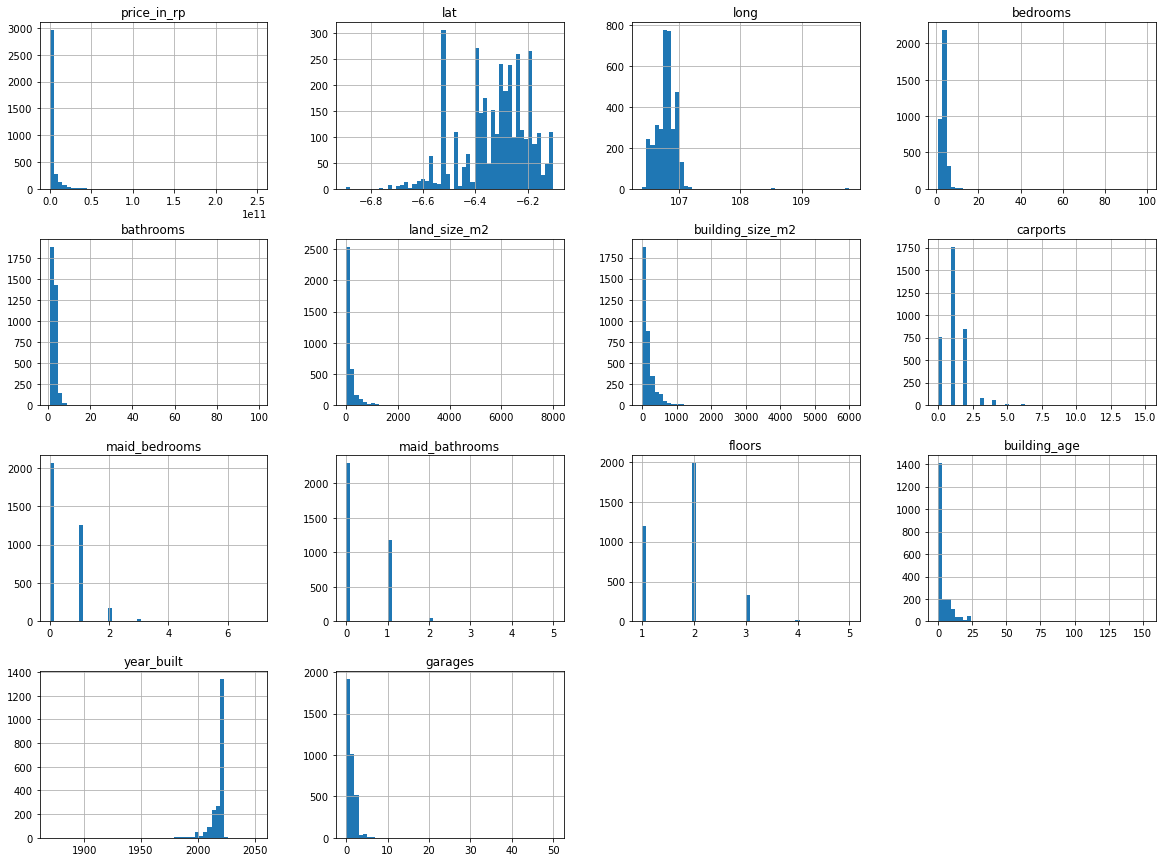

In [54]:
house_df.hist(bins=50, figsize=(20,15), )
plt.show()

#### **Price Records**

In [8]:
{"tags": ["hide-input"]}

house_df[['price_in_rp']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count             mean               std           min  \
price_in_rp 3,553.00 4,191,684,773.43 13,750,673,820.54 42,000,000.00   

                      median                max  
price_in_rp 1,500,000,000.00 580,000,000,000.00

Surely, standard deviation of `price_in_rp` is inflated by a nonproportionally large maximum price records. Currently largest value is Rp. 580 Billion. After inspecting, turns out that in the description, it explains that the price should be Rp. 5.8 Billion.

In [9]:
house_df.loc[house_df.price_in_rp == 580000000000, 'price_in_rp'] = 5800000000

The minimum price is also suspicious for typical house price in Jabodetabek (only Rp. 42 million). 

In [10]:
minimum_price = house_df.loc[
        house_df.price_in_rp == 42000000, 
        ['url', 'price_in_rp', 'bedrooms', 'land_size_m2', 'building_size_m2', 'floors']
    ]
minimum_price

url   price_in_rp  \
159  https://www.rumah123.com/properti/bekasi/hos11... 42,000,000.00   
340  https://www.rumah123.com/properti/bekasi/hos11... 42,000,000.00   

     bedrooms  land_size_m2  building_size_m2  floors  
159         2         60.00             40.00       1  
340         2         60.00             40.00       1

After further inspection, turns out those records are house listing offer for *Credit Transfer*, and the price records are the *Credit Transfer Fee*. We should remove those records and other *Credit Transfer* offers since those sample may disturb our price distribution and irrelevant for our subject of analysis.

In [11]:
price_records_to_drop = [
    42000000, 70000000, 75000000, 85000000, 100000000, 130000000,
    135000000
    ]
url_to_drop = [
    'https://www.rumah123.com/properti/bogor/hos11086291/#qid~a3b85dc6-9dd7-4fa9-9eac-113f4eba7868',
    'https://www.rumah123.com/properti/tangerang/hos11359461/#qid~0d9492e8-7326-465d-85ee-e54559fedc26',
    'https://www.rumah123.com/properti/bogor/hos11351345/#qid~9ab0b10c-8ceb-4c9a-9e7a-479f91a141d1'
    ]
for price in price_records_to_drop:
    house_df.drop(
        house_df[house_df.price_in_rp == price].index,
        inplace=True)
for url in url_to_drop:
    house_df.drop(
        house_df[house_df.url == url].index,
        inplace=True)
house_df[house_df.url == 'https://www.rumah123.com/properti/bekasi/hos11222131/#qid~aeb345f5-d0dd-46bf-8173-9872e4274ee2']\
    .price_in_rp == 1250000000

house_df[['price_in_rp']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count             mean              std            min  \
price_in_rp 3,537.00 4,047,847,610.97 9,801,801,133.07 125,000,000.00   

                      median                max  
price_in_rp 1,500,000,000.00 250,000,000,000.00

Above codes is our best approach to fix some minimum values.

In later chapter, we will analyze the effect of the suspicious prices using the more proven statistical approaches such as `outliers detection`, `high leverage observation`, and `cook distance`.

#### **Bedrooms & Bathrooms Records**

In [12]:
{"tags": ["hide-input"]}

house_df[['bedrooms', 'bathrooms']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count  mean  std  min  median   max
bedrooms  3,504.00  3.33 2.68 1.00    3.00 99.00
bathrooms 3,508.00  2.63 2.70 1.00    2.00 99.00

In [13]:
pd.DataFrame({
    'count':house_df[['bedrooms']].value_counts().sort_index()
}).T

bedrooms   1    2     3    4    5   6   7   8  9 10 11 12 13 16 20 21 36 37  \
count     19  942  1379  802  218  93  14  10  2  5  2  5  2  2  2  1  1  1   

bedrooms 50 54 57 99  
count     1  1  1  1

In [14]:
{"tags": ["hide-input"]}

pd.DataFrame({
    'count':house_df[['bathrooms']].value_counts().sort_index()
}).T

bathrooms    1     2    3    4    5   6   7   8  9 10 11 12 13 15 16 20 21 36  \
count      766  1120  979  446  111  33  20  10  3  3  2  3  1  2  1  2  1  1   

bathrooms 50 54 57 99  
count      1  1  1  1

Simple logic, house with a large amount of bedrooms/bathrooms tends to associated with large building size. House with >= 20 bedrooms may raise suspicion (especially 99!).

In [15]:
large_bedrooms_inst = house_df.loc[
        house_df.bedrooms >= 20, 
        ['url', 'price_in_rp', 'bedrooms', 'land_size_m2', 'building_size_m2', 'floors']
    ].sort_values('bedrooms')

large_bedrooms_inst

url       price_in_rp  \
2283  https://www.rumah123.com/properti/jakarta-sela... 26,000,000,000.00   
2545  https://www.rumah123.com/properti/jakarta-sela... 27,000,000,000.00   
2282  https://www.rumah123.com/properti/jakarta-sela... 26,000,000,000.00   
346   https://www.rumah123.com/properti/bekasi/hos11...  9,000,000,000.00   
1333  https://www.rumah123.com/properti/bogor/hos109...  2,700,000,000.00   
2483  https://www.rumah123.com/properti/jakarta-sela... 30,000,000,000.00   
2687  https://www.rumah123.com/properti/jakarta-sela... 28,000,000,000.00   
2634  https://www.rumah123.com/properti/jakarta-sela... 11,800,000,000.00   
2888  https://www.rumah123.com/properti/tangerang/ho... 55,000,000,000.00   

      bedrooms  land_size_m2  building_size_m2  floors  
2283        20        915.00            600.00       2  
2545        20      1,195.00            950.00       2  
2282        21        900.00            700.00       2  
346         36        939.00            500.00       1  
1333        37        500.00            350.00       1  
2483        50        517.00          2,417.00       5  
2687        54        890.00          1,800.00       5  
2634        57        491.00          1,500.00       4  
2888        99      1,150.00          6,000.00       4

Turns out that houses with large number of bedrooms is either `boarding house `(*kost*) or `guest house`.

#### **Garages**

In [16]:
{"tags": ["hide-input"]}

house_df[['garages']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count  mean  std  min  median   max
garages 3,537.00  0.71 1.31 0.00    0.00 50.00

In [17]:
{"tags": ["hide-input"]}

pd.DataFrame({
    'count':house_df[['garages']].value_counts().sort_index()
}).T

garages     0     1    2   3   4  5   6 10 12 20 50
count    1914  1010  518  31  42  6  10  3  1  1  1

Let's inspect house with 50 garages:

In [18]:
large_garages_inst = house_df.loc[
        house_df.garages >= 50, 
        ['url', 'price_in_rp', 'bedrooms', 'land_size_m2', 'building_size_m2', 'floors', 'garages']
    ]

large_garages_inst

url       price_in_rp  \
2888  https://www.rumah123.com/properti/tangerang/ho... 55,000,000,000.00   

      bedrooms  land_size_m2  building_size_m2  floors  garages  
2888        99      1,150.00          6,000.00       4       50

Turns out that houses with large number of garages is the house with 50 bedrooms i.e. the `boarding house `(*kost*), which explains the provided capacities for vehicle.

## 2.4. Zeroes and Missing Records

#### **Zeroes Records**

Records containing zero values are rather not ambiguous. For example, if `maid_bedrooms = 0`, it explains that this house doesn't provide bedroom for maid. Similar reasoning can safely be applied for other features, except for: `price in rp`, `lat`, `long`, `bedrooms`, `bathrooms`, `lands & building size`, and `floors`.

Let's explore proportion of zeroes records for each feature contains numerical data:

In [19]:
numerical_features = house_df.select_dtypes(exclude=['object', 'category']).columns
total_records = house_df.shape[0]
zeroes = (house_df[numerical_features] == 0).sum()
zeroes_percent = zeroes / total_records * 100
data_types = house_df[numerical_features].dtypes

pd.DataFrame({'Zeroes Count': zeroes, 
    'Zeroes Percentage (%)': zeroes_percent,
    'Data Types': data_types
})

Zeroes Count  Zeroes Percentage (%) Data Types
price_in_rp                  0                   0.00    float64
lat                          0                   0.00    float64
long                         0                   0.00    float64
bedrooms                     0                   0.00      Int64
bathrooms                    0                   0.00      Int64
land_size_m2                 0                   0.00    float64
building_size_m2             0                   0.00    float64
carports                   752                  21.26      Int64
maid_bedrooms             2062                  58.30      Int64
maid_bathrooms            2297                  64.94      Int64
floors                       0                   0.00      Int64
building_age              1044                  29.52      Int64
year_built                   0                   0.00      Int64
garages                   1914                  54.11      Int64

Fortunately, primary characteristics of the house doesn't contains zeroes. 

#### **Missing Records**

Let's fist explore missing records for numerical features.

In [20]:
nans = (house_df[numerical_features].isna()).sum()
nans_percent = nans / total_records * 100
data_types = house_df[numerical_features].dtypes

pd.DataFrame({'NaN Count': nans, 
    'NaN Percentage (%)': nans_percent,
    'Data Types': data_types
})

NaN Count  NaN Percentage (%) Data Types
price_in_rp               0                0.00    float64
lat                       0                0.00    float64
long                      0                0.00    float64
bedrooms                 33                0.93      Int64
bathrooms                29                0.82      Int64
land_size_m2              2                0.06    float64
building_size_m2          2                0.06    float64
carports                  0                0.00      Int64
maid_bedrooms             0                0.00      Int64
maid_bathrooms            0                0.00      Int64
floors                    6                0.17      Int64
building_age           1443               40.80      Int64
year_built             1443               40.80      Int64
garages                   0                0.00      Int64

Almost half of the dataset contains observations with missing `building_age`, so deducting analysis from this features is not appropriate.

For other features with missing records, it is safe to ignore those observations since they only cover less than 1% of total rows in the dataset.

For categorical and string features:

In [21]:
non_numeric_features = house_df.select_dtypes(include=['object', 'category']).columns
nans = (house_df[non_numeric_features].isna()).sum()
nans_percent = nans / total_records * 100
data_types = house_df[non_numeric_features].dtypes

pd.DataFrame({'NaN Count': nans, 
    'NaN Percentage (%)': nans_percent,
    'Data Types': data_types
})

NaN Count  NaN Percentage (%) Data Types
url                           0                0.00     object
title                         0                0.00     object
address                       0                0.00     object
district                      0                0.00     object
city                          0                0.00     object
facilities                    0                0.00     object
property_type                 1                0.03   category
ads_id                        4                0.11     object
certificate                 141                3.99   category
electricity                   0                0.00   category
property_condition          245                6.93   category
building_orientation       1640               46.37   category
furnishing                  386               10.91   category

Other than `building_orientation`, those features suffers from zero to slightly missing records.

# 3. Data Exploration

## 3.1. Median Statistics of House Price

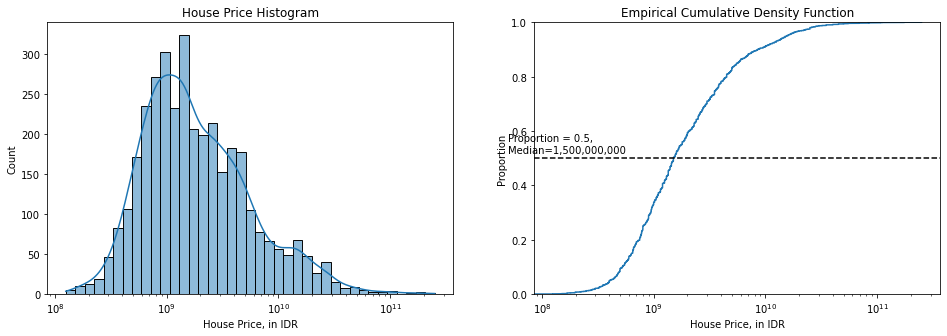

In [22]:
median = house_df['price_in_rp'].median()
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(
    data=house_df, x='price_in_rp', kde=True, 
    log_scale=True, ax=ax[0]
    )
sns.ecdfplot(
    data=house_df, x='price_in_rp', log_scale=True, ax=ax[1]
)
ax[0].set_title('House Price Histogram')
ax[1].axhline(y=0.5, ls='--', color='black')
ax[1].text(x=5*10e6, y=0.52, s=f'Proportion = 0.5,\nMedian={median:,.0f}')
ax[1].set_title('Empirical Cumulative Density Function')
for ax_ in ax:
    ax_.set_xlabel('House Price, in IDR')

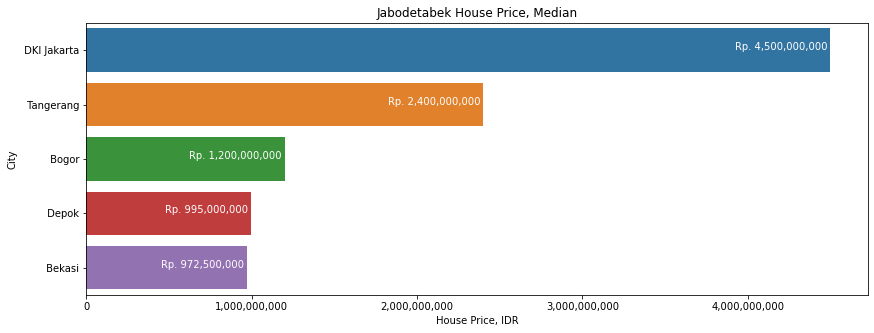

In [23]:
{"tags": ["hide-input"]}

house_df_simple = house_df.copy()
house_df_simple.loc[house_df_simple.city.str.contains('Jakarta'), 'city'] = ' DKI Jakarta'
median = house_df_simple[['city', 'price_in_rp']]\
    .groupby('city')\
    .aggregate(np.median)\
    .reset_index()\
    .sort_values('price_in_rp', ascending=False)
# plot_order = list(median.sort_values('price_in_rp', ascending=False).city)
plt.figure(figsize=(14, 5))
sns.barplot(y='city', x='price_in_rp',data=median)
for y, x in enumerate(median.price_in_rp):
    plt.text(x=x, y=y, s=f'Rp. {x:,.0f} ', ha='right', color='white')
plt.title('Jabodetabek House Price, Median')
plt.xlabel('House Price, IDR')
plt.ylabel('City')
current_xticks = plt.xticks()[0][:-1]
plt.xticks(current_xticks, ['{:,.0f}'.format(x) for x in current_xticks])
plt.show()


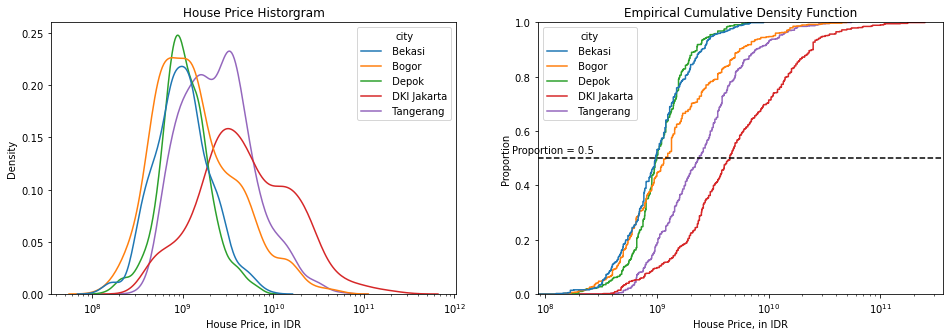

In [24]:
{"tags": ["hide-input"]}

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.kdeplot(
    data=house_df_simple, x='price_in_rp',
    log_scale=True, hue='city', ax=ax[0]
    )
sns.ecdfplot(
    data=house_df_simple, x='price_in_rp', 
    log_scale=True, hue='city', ax=ax[1]
)
ax[0].set_title('House Price Historgram')
ax[1].axhline(y=0.5, ls='--', color='black')
ax[1].text(x=5*10e6, y=0.52, s=f'Proportion = 0.5')
ax[1].set_title('Empirical Cumulative Density Function')
for ax_ in ax:
    ax_.set_xlabel('House Price, in IDR')

In [25]:
median_df = \
    house_df\
        .groupby('district')\
        .agg(median_price=('price_in_rp', np.median), unit_count=('price_in_rp', np.count_nonzero))\
        .reset_index()\
        .merge(house_df[['district','city', 'lat', 'long']].drop_duplicates(subset=['district']), on='district')\
        .sort_values('city')
hover_data = {
    'district': True,
    'city': True,
    'lat': False,
    'long': False,
    'median_price': ':,.0f',
    'unit_count': True
}    
fig = px.scatter_mapbox(
    median_df, lat='lat', lon='long', 
    color='city', size=(median_df.median_price / 10e3),
    hover_data=hover_data, hover_name='district'
)
fig.update_layout(
            title='Jabodetabek House Price Map',
            mapbox_style="carto-darkmatter",            
            autosize=True,
            hovermode='closest',
            )
fig.show(renderer='notebook')


#### **DKI Jakarta House Price**

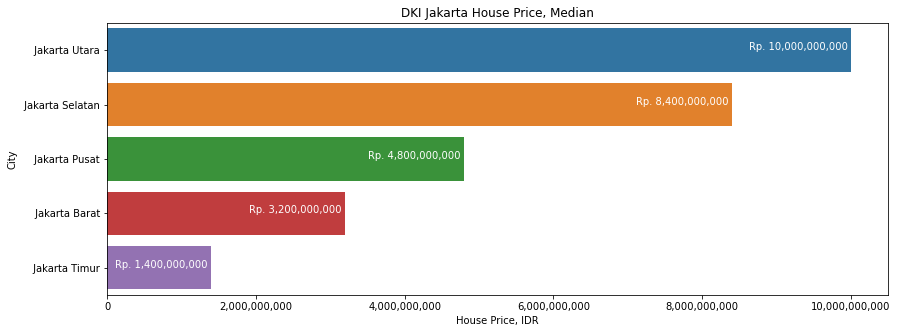

In [26]:
%matplotlib inline
house_df_jakarta = house_df[house_df.city.str.contains('Jakarta')]
median = house_df_jakarta[['city', 'price_in_rp']]\
    .groupby('city')\
    .aggregate(np.median)\
    .reset_index()\
    .sort_values('price_in_rp', ascending=False)
plt.figure(figsize=(14, 5))
sns.barplot(y='city', x='price_in_rp',data=median)
for y, x in enumerate(median.price_in_rp):
    plt.text(x=x, y=y, s=f'Rp. {x:,.0f} ', ha='right', color='white')
plt.title('DKI Jakarta House Price, Median')
plt.xlabel('House Price, IDR')
plt.ylabel('City')
current_xticks = plt.xticks()[0][:-1]
plt.xticks(current_xticks, ['{:,.0f}'.format(x) for x in current_xticks])
plt.show()

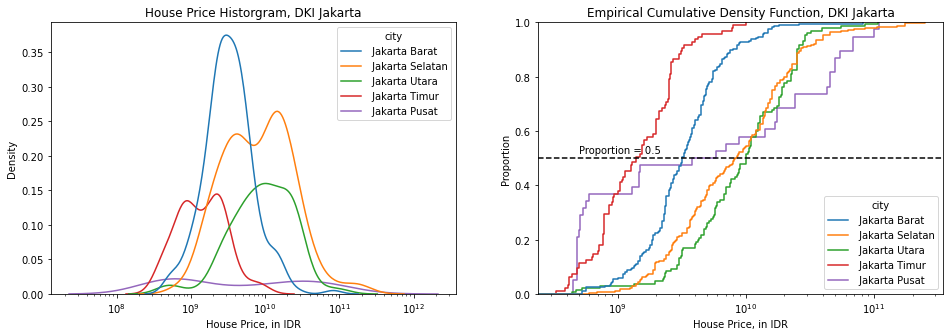

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.kdeplot(
    data=house_df_jakarta, x='price_in_rp',
    log_scale=True, hue='city', ax=ax[0]
    )
sns.ecdfplot(
    data=house_df_jakarta, x='price_in_rp', 
    log_scale=True, hue='city', ax=ax[1]
)
ax[0].set_title('House Price Historgram, DKI Jakarta')
ax[1].axhline(y=0.5, ls='--', color='black')
ax[1].text(x=5*10e7, y=0.52, s=f'Proportion = 0.5')
ax[1].set_title('Empirical Cumulative Density Function, DKI Jakarta')
for ax_ in ax:
    ax_.set_xlabel('House Price, in IDR')

#### **Inferences about Median House Price**

In [28]:
house_df[['price_in_rp']].describe(percentiles=[0.5]).T.rename(columns={'50%': 'median'})

count             mean              std            min  \
price_in_rp 3,537.00 4,047,847,610.97 9,801,801,133.07 125,000,000.00   

                      median                max  
price_in_rp 1,500,000,000.00 250,000,000,000.00

In [29]:
median = np.median(house_df.price_in_rp)
price_data = house_df.price_in_rp.values
median_ci_mj = [
    float(ci) for ci in mquantiles_cimj(
        data=price_data,
        prob=[0.5],
        alpha=0.05)
    ]
median_ci_hs = median_cihs(
        data=price_data,
        alpha=0.05
        )
median_ci_bootstrap = [
    float(ci) for ci in bootstrap(
        data=(price_data, ), method='percentile',
        statistic=np.median, random_state=99).confidence_interval
    ]
median_ci = [
    {'method': method, 'median':median, 'ci_lower': ci[0], 'ci_upper': ci[1]}\
        for method, median, ci in zip(
            ['Maritz-Jarrett', 'Hetmasperger-Sheather', 'Bootstrap CI'],
            [i for i in itertools.repeat(median, 3)],
            [median_ci_mj, median_ci_hs, median_ci_bootstrap]
            )
]

pd.DataFrame(median_ci)


method           median         ci_lower         ci_upper
0         Maritz-Jarrett 1,500,000,000.00 1,434,922,950.41 1,565,077,049.59
1  Hetmasperger-Sheather 1,500,000,000.00 1,450,000,000.00 1,590,000,000.00
2           Bootstrap CI 1,500,000,000.00 1,450,000,000.00 1,590,000,000.00

In [30]:
from scipy.stats import gaussian_kde

density = gaussian_kde(price_data)

In [31]:
from scipy.optimize import root_scalar

def get_cdf(upper_bound):
    density = gaussian_kde(price_data)
    return (density.integrate_box(-np.inf, upper_bound) - 0.5)

solver = root_scalar(get_cdf, method='secant',  xtol=10e-5, x0=1500000000, x1=1600000000)
print('Median: Rp. {:,.2f}'.format(solver.root))

Median: Rp. 2,144,961,435.51


In [32]:
class CoverageProba():
    def __init__(self, dataset, alpha, n_sample):
        self._dataset = dataset
        self._alpha = alpha
        self._n_sample = n_sample.copy()
        self._density = gaussian_kde(self._dataset)
        self._median = root_scalar(
            self._get_cdf, 
            method='secant',  xtol=10e-5, 
            x0=np.quantile(self._dataset, q=0.25), 
            x1=np.quantile(self._dataset, q=0.75)
            ).root
        self._proba_mj = []
        self._proba_hs = []
        self._proba_bootstrap = []
        
    def _get_cdf(self, upper_bound):
        return (self._density.integrate_box(-np.inf, upper_bound) - 0.5)

    def _median_ci_mj(self, n_sample, a): # dataset in np.array
        n_sample_ = n_sample
        sample = self._density.resample(n_sample_)[0]
        ci_l, ci_h = [float(ci) for ci in mquantiles_cimj(
                    data=sample,
                    prob=[0.5],
                    alpha=self._alpha)
                    ]
        return (self._median >= ci_l and self._median <= ci_h)
    
    def _median_ci_hs(self, n_sample, a):
        n_sample_ = n_sample
        sample = self._density.resample(n_sample_)[0]
        ci_l, ci_h =  median_cihs(
                    data=sample,
                    alpha=self._alpha
                    )
        return (self._median >= ci_l and self._median <= ci_h)        
    
    def _median_ci_bootstrap(self, n_sample, a):
        n_sample_ = n_sample
        sample = self._density.resample(n_sample_)[0]
        ci_l, ci_h = [float(ci) for ci in bootstrap(
                    data=(sample, ), method='percentile',
                    statistic=np.median).confidence_interval
                    ]
        return (self._median >= ci_l and self._median <= ci_h)

    def get_proba(self, n_iterate):
        n_iterate_ = n_iterate
        median_ci_mj_vec = np.vectorize(self._median_ci_mj)
        median_ci_hs_vec = np.vectorize(self._median_ci_hs)
        median_ci_bootstrap_vec = np.vectorize(self._median_ci_bootstrap)
        for i in self._n_sample:
            a = np.empty((n_iterate_, 1))
            ci_mj = np.apply_along_axis(lambda x: median_ci_mj_vec(i, x), 0, a)
            self._proba_mj.append(np.sum(ci_mj) / n_iterate_)
            ci_hs = np.apply_along_axis(lambda x: median_ci_hs_vec(i, x), 0, a)
            self._proba_hs.append((np.sum(ci_hs) / n_iterate_))
            ci_bootstrap = np.apply_along_axis(lambda x: median_ci_bootstrap_vec(i, x), 0, a)
            self._proba_bootstrap.append((np.sum(ci_bootstrap) / n_iterate_))
        return (
            pd.DataFrame(
                {'sample_sizes': self._n_sample,
                'coverage_probability_mj': self._proba_mj,
                'coverage_probability_hs': self._proba_hs,
                'coverage_probability_bootstrap': self._proba_bootstrap
                }
            )
        )

In [34]:
coverage = CoverageProba(
    dataset=price_data, 
    alpha=0.05, 
    n_sample=[10, 50, 100, 1000, 2000]
    )
ci_coverage = coverage.get_proba(n_iterate=1000)

ci_coverage

sample_sizes  coverage_probability_mj  coverage_probability_hs  \
0            10                     0.98                     0.93   
1            50                     0.94                     0.94   
2           100                     0.95                     0.96   
3          1000                     0.94                     0.94   
4          2000                     0.96                     0.95   

   coverage_probability_bootstrap  
0                            0.94  
1                            0.96  
2                            0.94  
3                            0.94  
4                            0.94

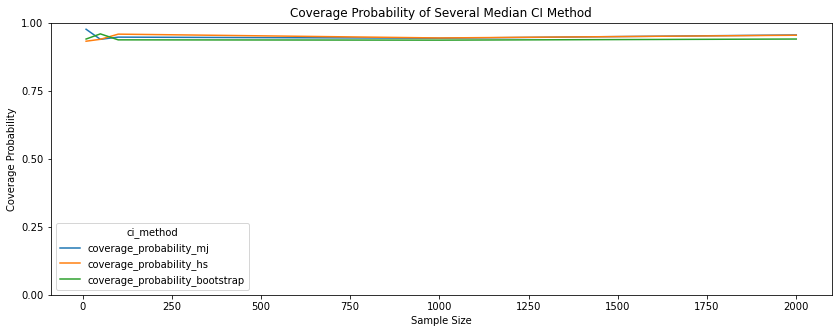

In [35]:
ci_coverage_melt = pd.melt(
    ci_coverage.copy(), id_vars='sample_sizes', 
    value_vars=['coverage_probability_mj', 'coverage_probability_hs', 'coverage_probability_bootstrap'],
    var_name='ci_method', value_name='coverage_probability'
)
# plot coverage probability
plt.figure(figsize=(14, 5))
sns.lineplot(data=ci_coverage_melt, x='sample_sizes', y='coverage_probability', hue='ci_method')
plt.yticks(np.linspace(0, 1, 5))
plt.xlabel('Sample Size')
plt.ylabel('Coverage Probability')
plt.title('Coverage Probability of Several Median CI Method')
plt.show()

In [36]:
def median_ci_hs(array, alpha=0.05, output='upper'):
    ci_l, ci_h = median_cihs(
            data=array,
            alpha=alpha
            )
    if output =='lower':
        return ci_l
    return ci_h

def get_ci_df(df):
    df_ = df.copy()
    return (df_[['city', 'price_in_rp']]\
        .groupby('city')\
        .aggregate(
            median=pd.NamedAgg(column='price_in_rp', aggfunc=np.median),
            ci_lower = pd.NamedAgg(column='price_in_rp', aggfunc=lambda x: median_ci_hs(x, output='lower')),
            ci_upper = pd.NamedAgg(column='price_in_rp', aggfunc=lambda x: median_ci_hs(x))
        )\
        .reset_index()\
        .sort_values('median')
    )

house_df_simple = house_df.copy()
house_df_simple.loc[house_df_simple.city.str.contains('Jakarta'), 'city'] = ' DKI Jakarta'  
median_ci_jabodetabek = get_ci_df(house_df_simple)

median_ci_jabodetabek

city           median         ci_lower         ci_upper
0        Bekasi   972,500,000.00   916,777,805.81 1,050,000,000.00
3         Depok   995,000,000.00   945,417,204.91 1,050,000,000.00
1         Bogor 1,200,000,000.00 1,090,911,593.92 1,350,000,000.00
4     Tangerang 2,400,000,000.00 2,168,813,480.34 2,600,000,000.00
2   DKI Jakarta 4,500,000,000.00 3,990,000,000.00 4,900,000,000.00

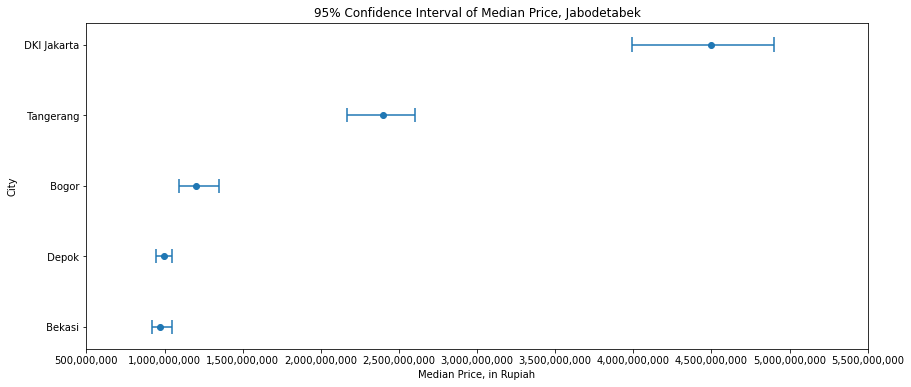

In [37]:
def plot_ci(df, title):
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    ax.hlines(y=df.city, xmin=df.ci_lower, xmax=df.ci_upper)
    y_ticks = np.array(ax.get_yticks())
    x_ticks = ax.get_xticks()
    x_ticks = x_ticks.copy()[x_ticks.copy() >= 0]
    ax.vlines(x=df.ci_lower, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax.vlines(x=df.ci_upper, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax.scatter(x=df['median'], y=df.city)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in x_ticks])
    ax.set_title(f'95% Confidence Interval of Median Price, {title}')
    ax.set_xlabel('Median Price, in Rupiah')
    ax.set_ylabel('City')

plot_ci(median_ci_jabodetabek, 'Jabodetabek')

In [38]:
median_ci_jakarta = get_ci_df(house_df_jakarta)

median_ci_jakarta

city            median         ci_lower          ci_upper
3     Jakarta Timur  1,400,000,000.00 1,050,000,000.00  2,000,000,000.00
0     Jakarta Barat  3,200,000,000.00 2,750,000,000.00  3,651,516,112.22
1     Jakarta Pusat  4,800,000,000.00   585,964,530.25 17,500,000,000.00
2   Jakarta Selatan  8,400,000,000.00 6,250,000,000.00 10,627,713,948.40
4     Jakarta Utara 10,000,000,000.00 7,700,000,000.00 12,000,000,000.00

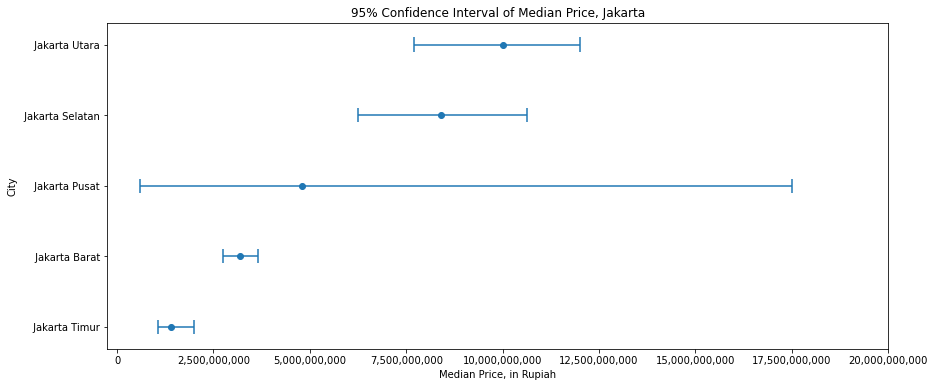

In [39]:
plot_ci(median_ci_jakarta, 'Jakarta')

## 3.2. House Price according to Certificate Type

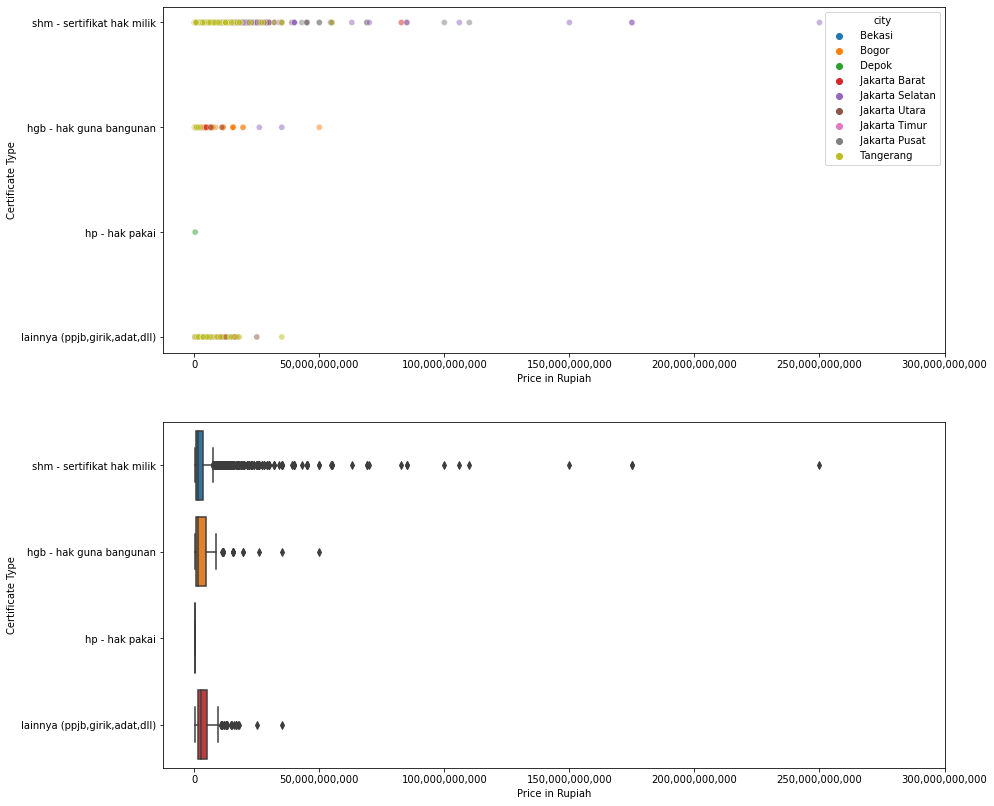

In [40]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
sns.scatterplot(data=house_df, y='certificate', x='price_in_rp', hue='city', ax=ax[0], alpha=0.5)
sns.boxplot(data=house_df, y='certificate', x='price_in_rp', ax=ax[1])
for ax_ in ax:
    ticks = ax_.get_xticks()
    xticks = ticks[ticks >= 0]
    ax_.set_xticks(xticks)
    ax_.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in xticks])
    ax_.set_xlabel('Price in Rupiah')
    ax_.set_ylabel('Certificate Type')

In [41]:
def median_diff(sample_1, sample_2):
    statistic = np.median(sample_1) - np.median(sample_2)
    return statistic

sample_size = 50
city = ' Bogor'
categories = ['shm - sertifikat hak milik', 'hgb - hak guna bangunan', 'lainnya (ppjb,girik,adat,dll)']
sample_1 = \
    house_df[(house_df.city == ' Bogor') & (house_df.certificate == 'shm - sertifikat hak milik')]\
        .price_in_rp.sample(sample_size).values
sample_2 = \
    house_df[(house_df.city == ' Bogor') & (house_df.certificate == 'hgb - hak guna bangunan')]\
        .price_in_rp.sample(sample_size).values
data = (sample_1, sample_2)
res = bootstrap(data, median_diff, method='basic', vectorized=False)

res.confidence_interval

ConfidenceInterval(low=-5970000000.0, high=-1037500000.0)

In [42]:
for column, order in zip(
    ['certificate', 'electricity', 'property_condition', 'furnishing'],
    [certificate_order, electricity_order, property_condition_order, furnishing_order]):
    house_df_simple[column] = \
        pd.Categorical(
            values=house_df_simple[column],
            categories=order,
            ordered=True
            )
cities = [' Bogor', ' Depok', ' Tangerang', ' Bekasi', ' DKI Jakarta']
categories = list(house_df_simple.certificate.dtypes.categories)
index = [i for i in range(len(categories))]
combination = [comb for comb in itertools.combinations(index, 2)]
records = []
sample_size = 10
for city in cities:
    df = house_df_simple[house_df_simple.city == city]
    for index_1, index_2 in combination:
        category_1 = categories[index_1]
        category_2 = categories[index_2]
        try:
            sample_1 = df[
                df.certificate == category_1
                ].price_in_rp.sample(sample_size).values
            sample_2 = df[
                df.certificate == category_2
                ].price_in_rp.sample(sample_size).values
        except (ValueError, IndexError):
            continue
        data = (sample_1, sample_2)
        res = bootstrap(data, median_diff, method='basic', vectorized=False)
        ci_l = res.confidence_interval[0]
        ci_h = res.confidence_interval[1]
        records.append({
            'city': city, 'category_1': category_1,
            'category_2': category_2, 'category': f'({category_1}) - ({category_2})',
            'ci_l': ci_l, 'ci_h': ci_h
        })

median_df_test = pd.DataFrame(records)

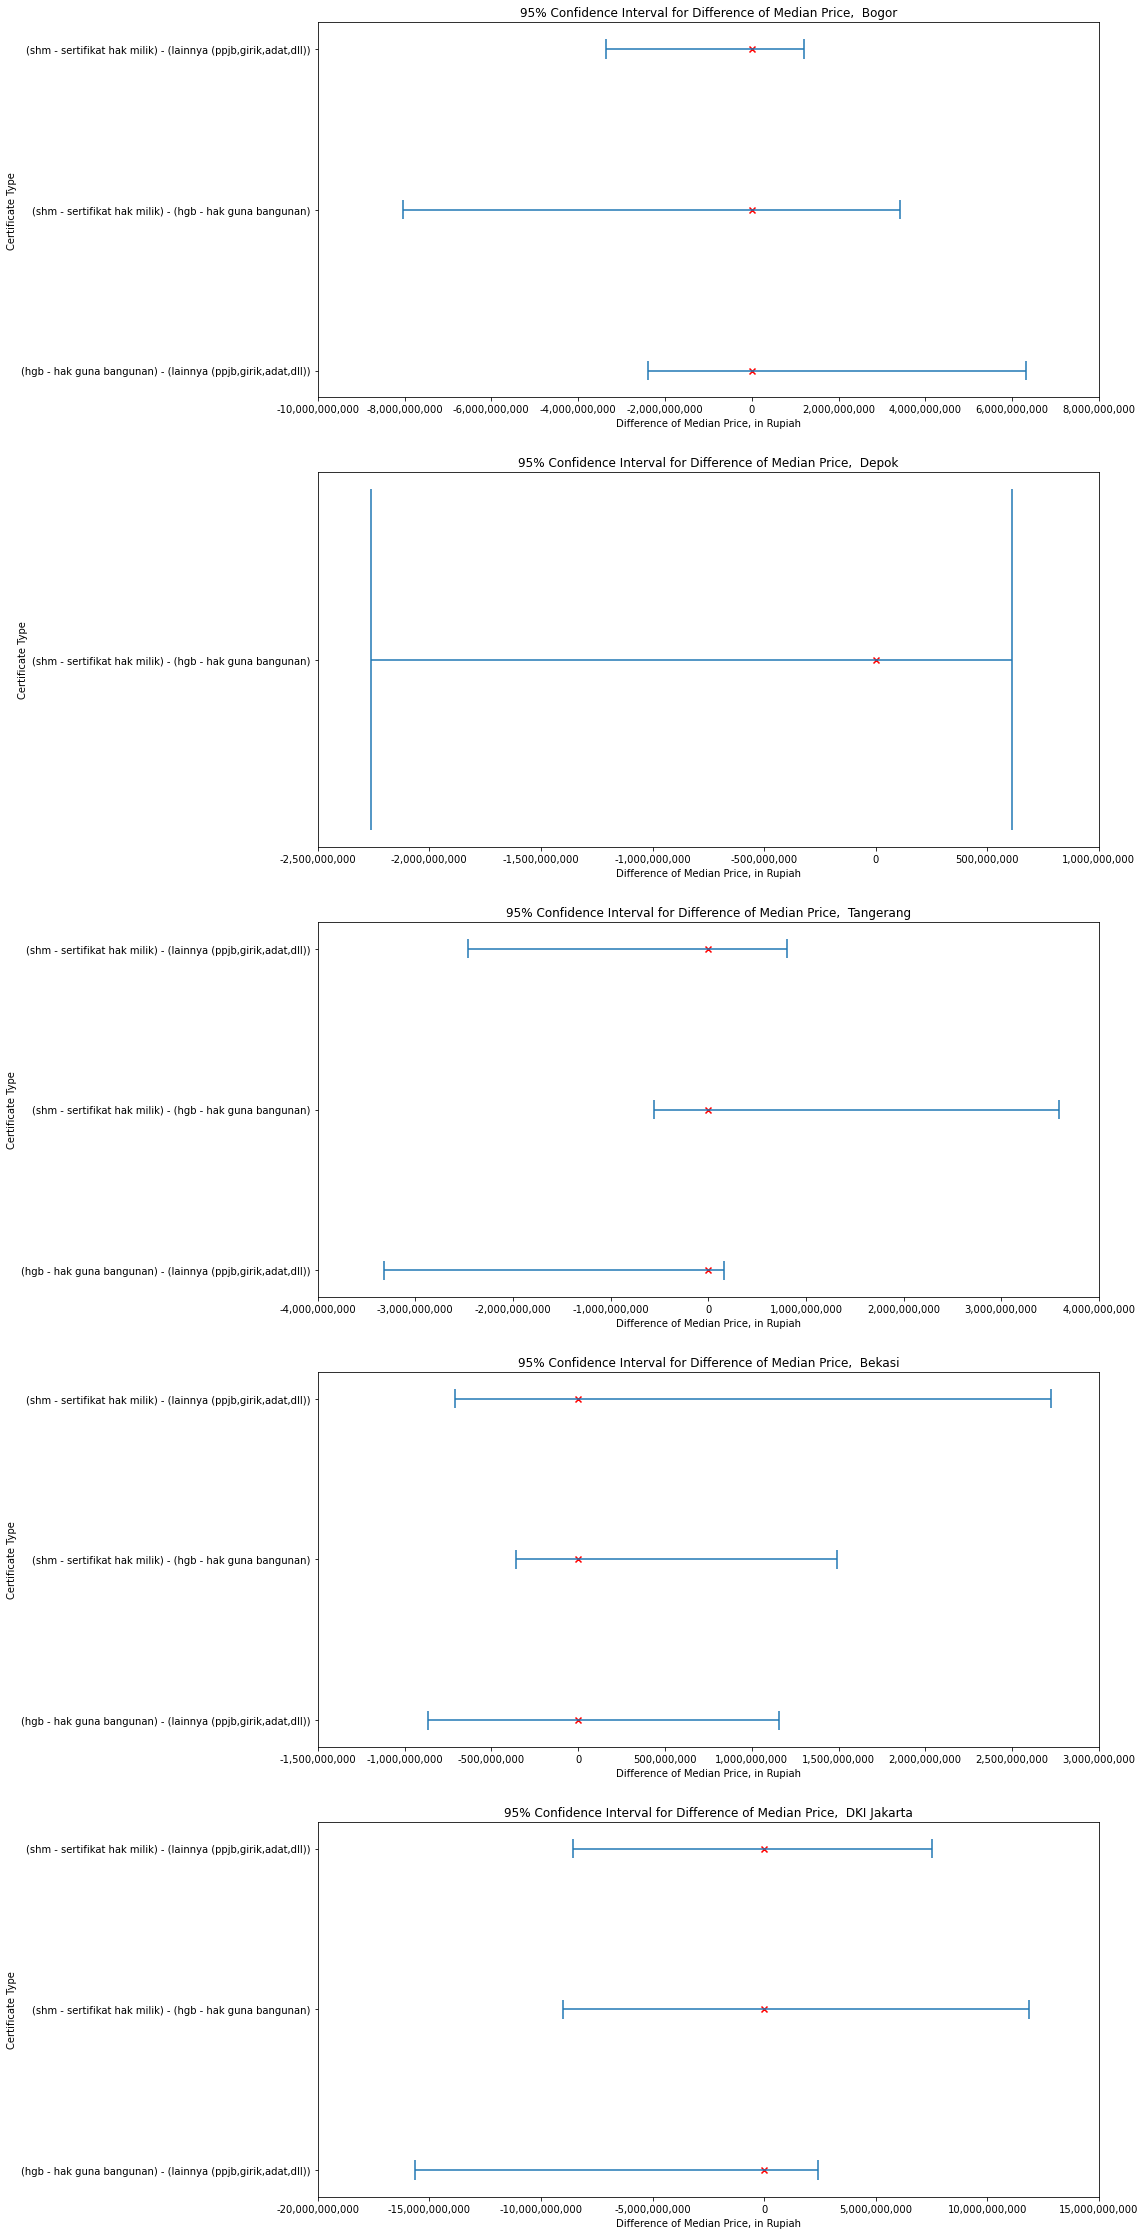

In [43]:
fig, ax = plt.subplots(len(cities), 1, figsize=(14, len(cities) * 8))

for index, city in enumerate(cities):
    df = median_df_test[median_df_test.city == city].sort_values('category_1')
    ax[index].hlines(y=df.category, xmin=df.ci_l, xmax=df.ci_h)
    y_ticks = np.array(ax[index].get_yticks())
    x_ticks = ax[index].get_xticks()
    ax[index].vlines(x=df.ci_l, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].vlines(x=df.ci_h, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].scatter(
        x=np.repeat(0, len(df.category)), y=df.category,
        marker='x', color='r')
    ax[index].set_xticks(x_ticks)
    ax[index].set_xticklabels(['{:,.0f}'.format(xtick) for xtick in x_ticks])
    ax[index].set_title(f'95% Confidence Interval for Difference of Median Price, {city}')
    ax[index].set_xlabel('Difference of Median Price, in Rupiah')
    ax[index].set_ylabel('Certificate Type')

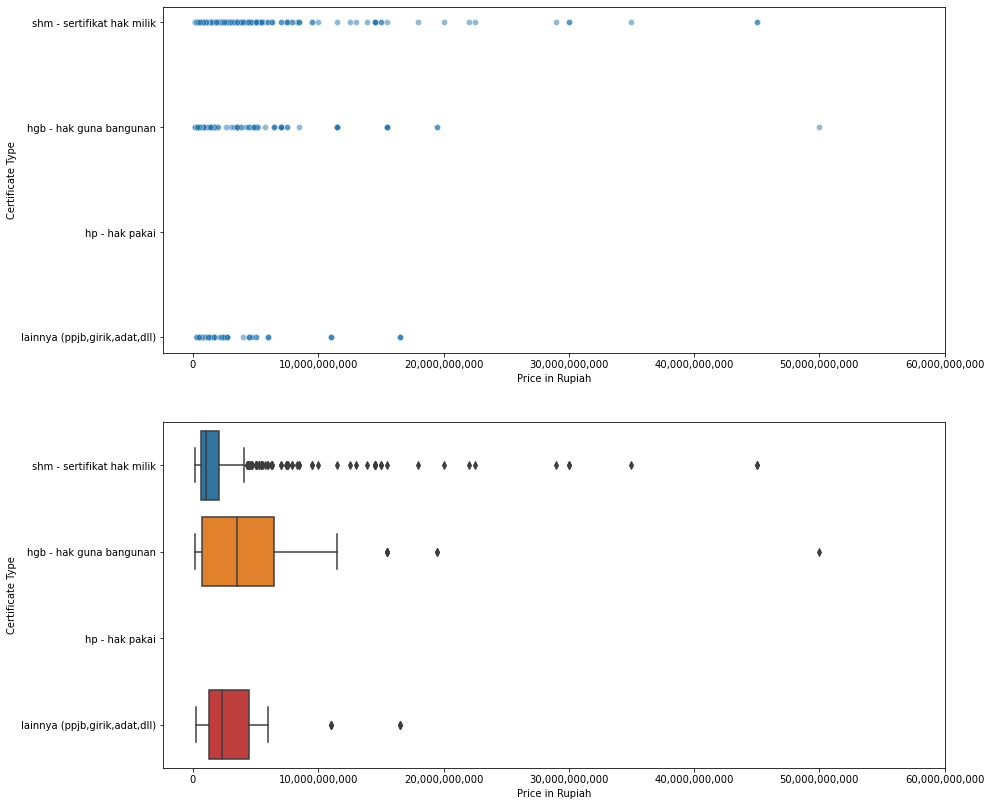

In [44]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
sns.scatterplot(data=house_df[house_df.city == ' Bogor'], y='certificate', x='price_in_rp', ax=ax[0], alpha=0.5)
sns.boxplot(data=house_df[house_df.city == ' Bogor'], y='certificate', x='price_in_rp', ax=ax[1])
for ax_ in ax:
    ticks = ax_.get_xticks()
    xticks = ticks[ticks >= 0]
    ax_.set_xticks(xticks)
    ax_.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in xticks])
    ax_.set_xlabel('Price in Rupiah')
    ax_.set_ylabel('Certificate Type')

## 3.3. House Price according to Property Condition

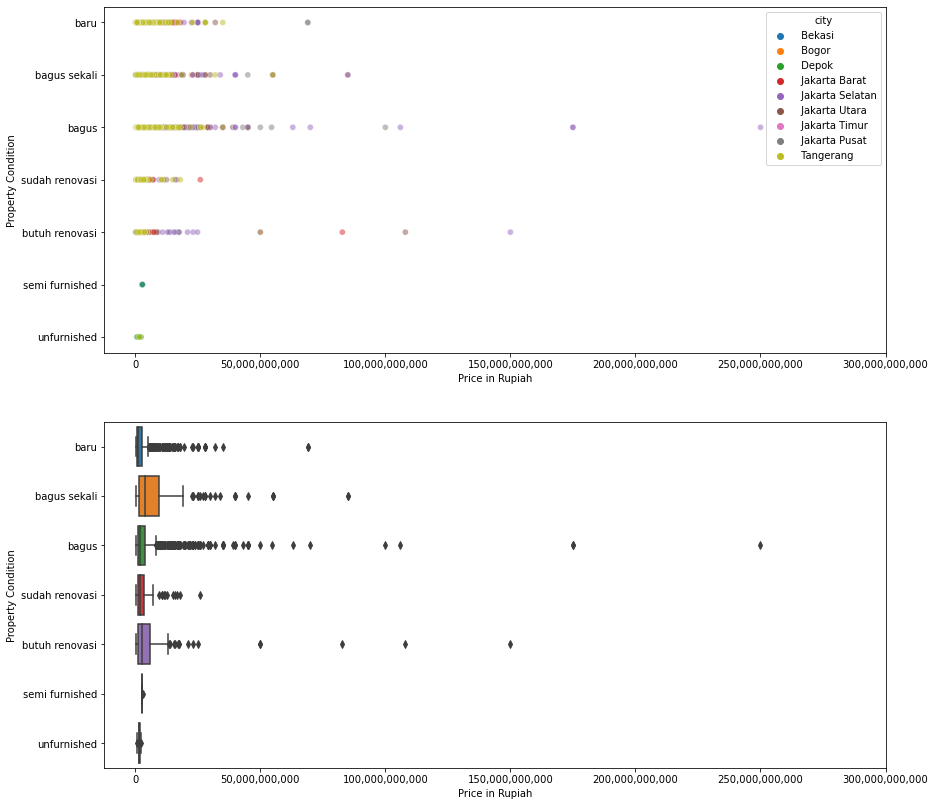

In [45]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
sns.scatterplot(data=house_df, y='property_condition', x='price_in_rp', hue='city', ax=ax[0], alpha=0.5)
sns.boxplot(data=house_df, y='property_condition', x='price_in_rp', ax=ax[1])
for ax_ in ax:
    ticks = ax_.get_xticks()
    xticks = ticks[ticks >= 0]
    ax_.set_xticks(xticks)
    ax_.set_xticklabels(['{:,.0f}'.format(xtick) for xtick in xticks])
    ax_.set_xlabel('Price in Rupiah')
    ax_.set_ylabel('Property Condition')

In [46]:
cities = [' Bogor', ' Depok', ' Tangerang', ' Bekasi', ' DKI Jakarta']
analyze_condition = ['baru', 'bagus sekali', 'bagus', 'sudah renovasi', 'butuh renovasi']
records = []
sample_size = 30
categories = list(house_df_simple.property_condition.dtypes.categories)
index = [i for i in range(len(categories))]
combination = [comb for comb in itertools.combinations(index, 2)]
for city in cities:
    df = house_df_simple[
        (house_df_simple.city == city) & (house_df.property_condition.isin(analyze_condition))]
    for index_1, index_2 in combination:
        category_1 = categories[index_1]
        category_2 = categories[index_2]
        try:
            sample_1 = df[
                df.property_condition == category_1
                ].price_in_rp.sample(sample_size).values
            sample_2 = df[
               df.property_condition == category_2
                ].price_in_rp.sample(sample_size).values
        except (ValueError, IndexError):
            continue
        data = (sample_1, sample_2)
        res = bootstrap(data, median_diff, method='basic', vectorized=False)
        ci_l = res.confidence_interval[0]
        ci_h = res.confidence_interval[1]
        records.append({
            'city': city, 'category_1': category_1,
            'category_2': category_2, 'category': f'({category_1}) - ({category_2})',
            'ci_l': ci_l, 'ci_h': ci_h
        })

median_df_test = pd.DataFrame(records)

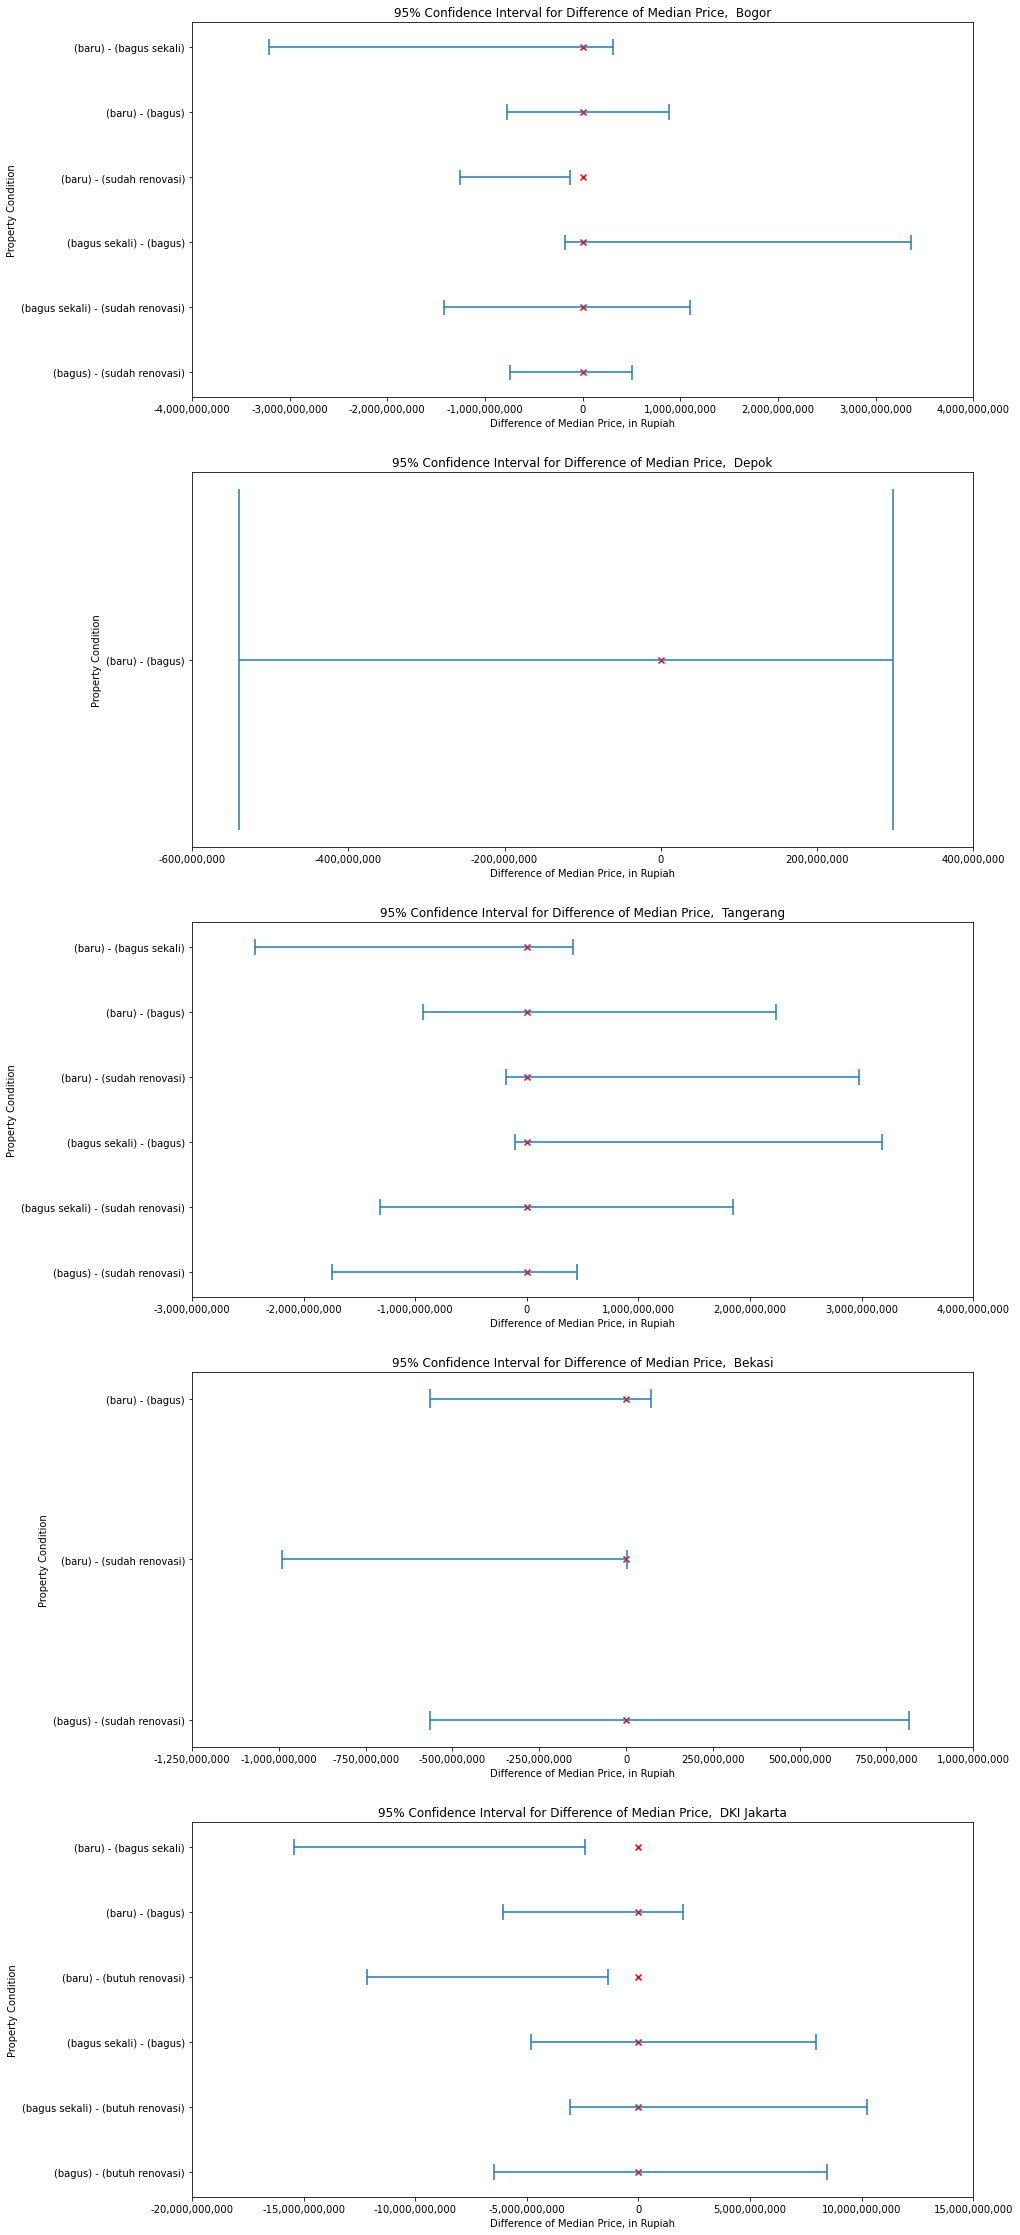

In [47]:
fig, ax = plt.subplots(len(cities), 1, figsize=(14, len(cities) * 8))

for index, city in enumerate(cities):
    df = median_df_test[median_df_test.city == city]
    df = df.iloc[::-1]
    ax[index].hlines(y=df.category, xmin=df.ci_l, xmax=df.ci_h)
    y_ticks = np.array(ax[index].get_yticks())
    x_ticks = ax[index].get_xticks()
    ax[index].vlines(x=df.ci_l, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].vlines(x=df.ci_h, ymin=(y_ticks - (len(y_ticks) * 0.02)), ymax=(y_ticks + (len(y_ticks) * 0.02)))
    ax[index].scatter(
        x=np.repeat(0, len(df.category)), y=df.category,
        marker='x', color='r')
    ax[index].set_xticks(x_ticks)
    ax[index].set_xticklabels(['{:,.0f}'.format(xtick) for xtick in x_ticks])
    ax[index].set_title(f'95% Confidence Interval for Difference of Median Price, {city}')
    ax[index].set_xlabel('Difference of Median Price, in Rupiah')
    ax[index].set_ylabel('Property Condition')

## 3.4. House Price according to Numerical Features

Text(0.5, 1.0, 'Tes')

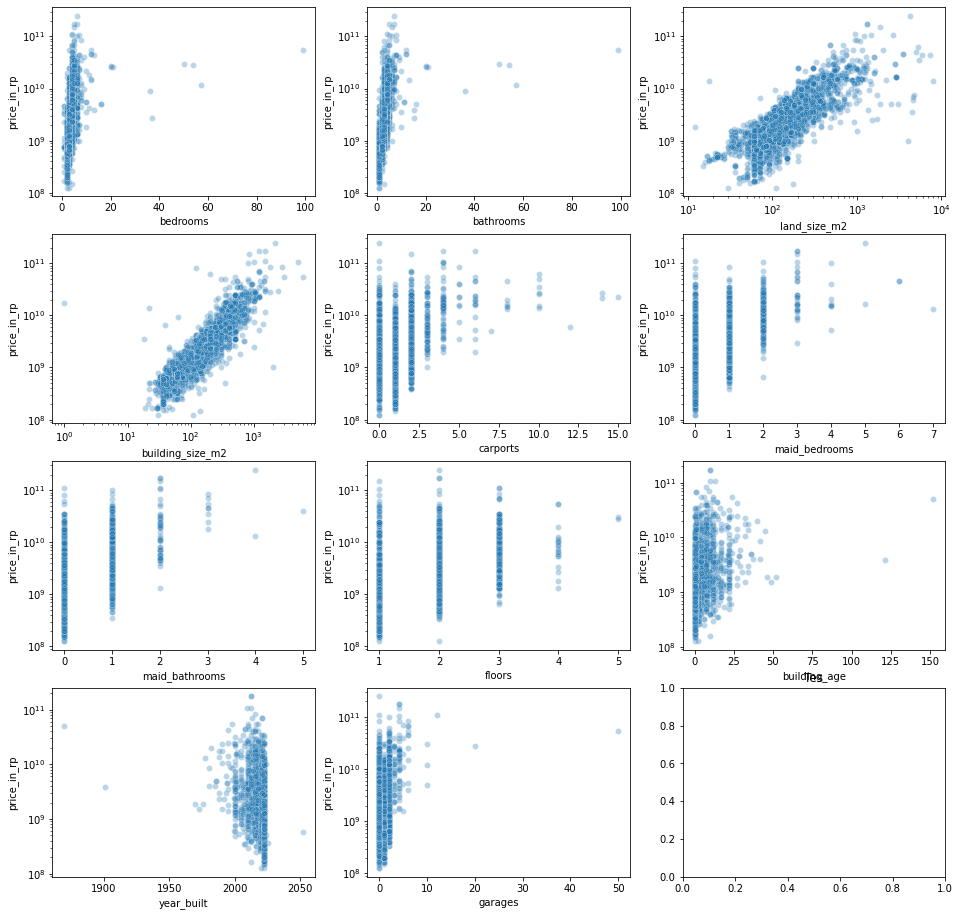

In [146]:
numerical_features = house_df\
    .select_dtypes(exclude=['object', 'category'])\
        .drop(['price_in_rp', 'year_built'], axis=1).columns

fig, ax = plt.subplots(5, 3, figsize=(22, 16))

for (ax_index, ax_), feature in zip(np.ndenumerate(ax), numerical_features):
    sns.scatterplot(data=house_df, x=feature, y='price_in_rp', alpha=0.3, ax=ax[ax_index])
    if house_df[feature].dtypes == 'float':
        ax[ax_index].set_xscale('log')
        ax[ax_index].set_yscale('log')
    else:
        ax[ax_index].set_yscale('log')

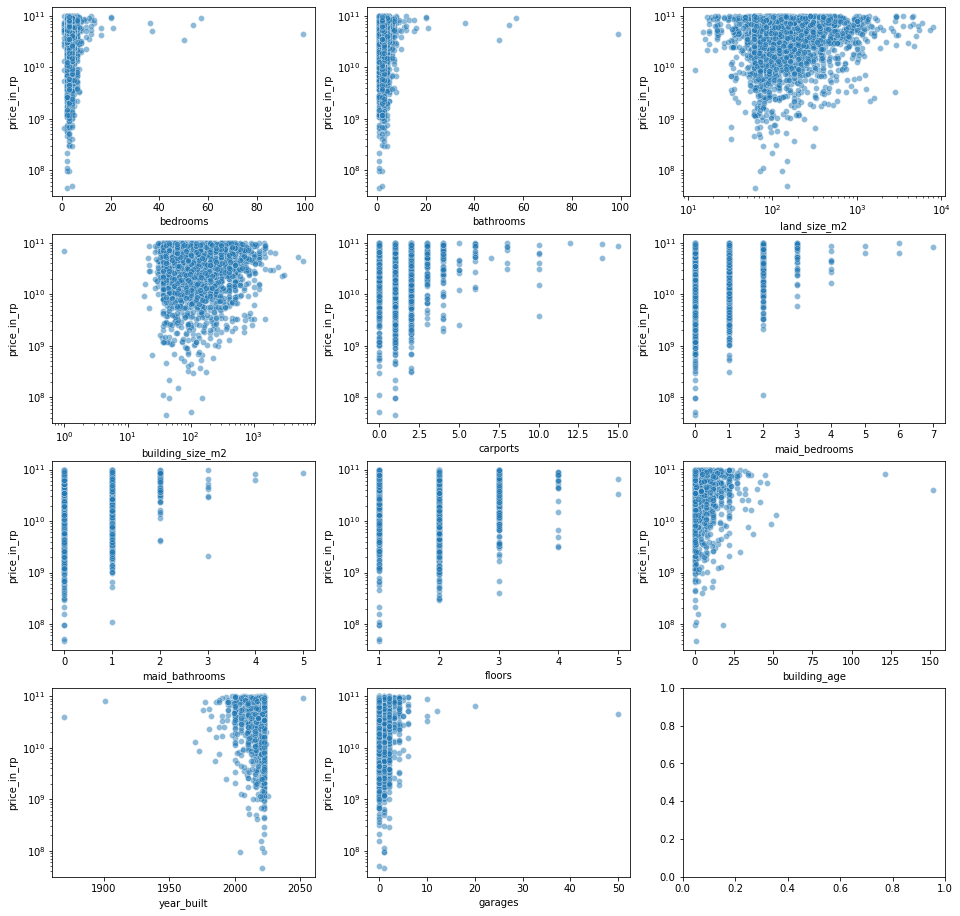

In [134]:
numerical_features = house_df\
    .select_dtypes(exclude=['object', 'category'])\
        .drop(['price_in_rp', 'year_built'], axis=1).columns

house_df_test_random = house_df.assign(
    price_in_rp = np.random.uniform(10000000, 100000000000, len(house_df.price_in_rp))
)

fig, ax = plt.subplots(5, 3, figsize=(24, 16))

for (ax_index, ax_), feature in zip(np.ndenumerate(ax), numerical_features):
    sns.scatterplot(data=house_df_test_random, x=feature, y='price_in_rp', alpha=0.5, ax=ax[ax_index])
    if house_df[feature].dtypes == 'float':
        ax[ax_index].set_xscale('log')
        ax[ax_index].set_yscale('log')
    else:
        ax[ax_index].set_yscale('log')

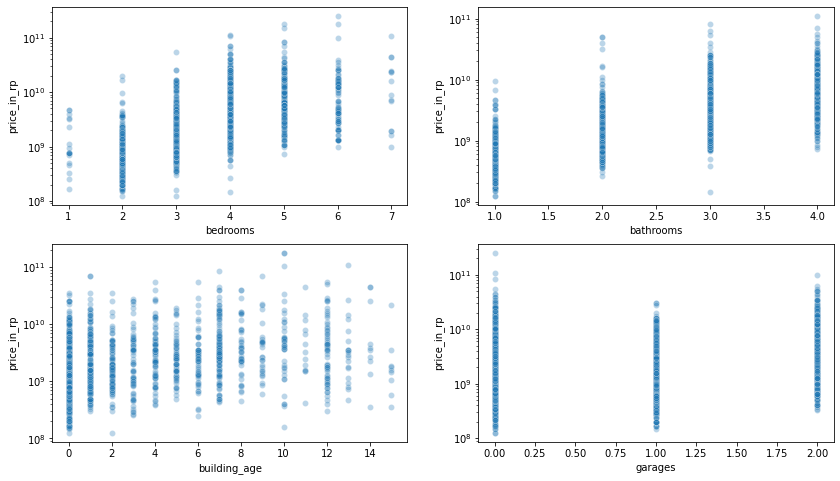

In [145]:
features = ['bedrooms', 'bathrooms', 'building_age', 'garages']

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

for (ax_index, ax_), feature in zip(np.ndenumerate(ax), features):
    q_lower = np.quantile(house_df[feature].dropna().values, 0.25)
    q_upper = np.quantile(house_df[feature].dropna().values, 0.75)
    iqr = (q_upper - q_lower)
    whisker_upper = q_upper + 1.5 * iqr
    df = house_df[house_df[feature] <= whisker_upper]
    sns.scatterplot(data=df, x=feature, y='price_in_rp', alpha=0.3, ax=ax[ax_index])
    if house_df[feature].dtypes == 'float':
        ax[ax_index].set_xscale('log')
        ax[ax_index].set_yscale('log')
    else:
        ax[ax_index].set_yscale('log')

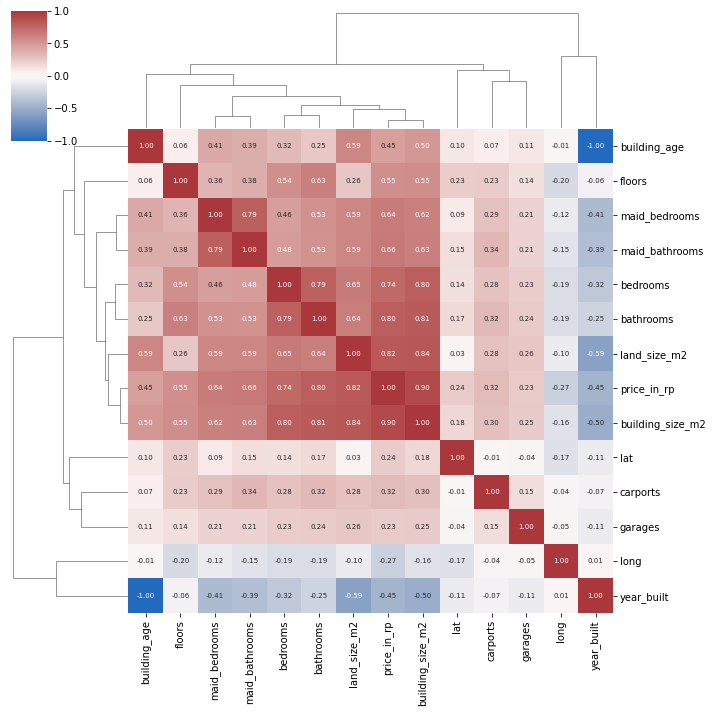

In [147]:
house_df_corr = house_df.corr(method='spearman')
sns.clustermap(house_df_corr, vmin=-1, vmax=1, center=0, cmap='vlag', annot=True, fmt='.2f', annot_kws={'size': 7})

# References

1. 'rumah123.com'